# Description

![title](img/titanic.png)


##### The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

###### One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

###### In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.



In [333]:
# Imports

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

### Load and preview data:

In [343]:
# get titanic & test csv files as a DataFrame
# Download here https://www.kaggle.com/c/titanic/data?train.csv
titanic_data = pd.read_csv("/Users/KRich/GitHub/data/titanic/train.csv")

# preview data
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [344]:
# split data
# Generate the training set.  Set random_state to be able to replicate results.
titanic_df = titanic_data.sample(frac=0.8, random_state=1)
# Select anything not in the training set and put it in the testing set.
test_df = titanic_data.loc[~titanic_data.index.isin(titanic_df.index)]
# Print the shapes of both sets.
print(titanic_df.shape)
print(test_df.shape)

# preview of revised data frame 
titanic_df.head()

(713, 12)
(178, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48.0,0,0,17466,25.9292,D17,S
223,224,0,3,"Nenkoff, Mr. Christo",male,NaN,0,0,349234,7.8958,NaN,S
84,85,1,2,"Ilett, Miss. Bertha",female,17.0,0,0,SO/C 14885,10.5000,NaN,S
680,681,0,3,"Peters, Miss. Katie",female,NaN,0,0,330935,8.1375,NaN,Q
535,536,1,2,"Hart, Miss. Eva Miriam",female,7.0,0,2,F.C.C. 13529,26.2500,NaN,S


In [345]:
# overview of the data
#------------------------------------
print("----------------------------")
print("Train data")
print("----------------------------")
titanic_df.info()
#------------------------------------
print("----------------------------")
print("Test data")
print("----------------------------")
test_df.info()

----------------------------
Train data
----------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 713 entries, 862 to 860
Data columns (total 12 columns):
PassengerId    713 non-null int64
Survived       713 non-null int64
Pclass         713 non-null int64
Name           713 non-null object
Sex            713 non-null object
Age            570 non-null float64
SibSp          713 non-null int64
Parch          713 non-null int64
Ticket         713 non-null object
Fare           713 non-null float64
Cabin          161 non-null object
Embarked       712 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 72.4+ KB
----------------------------
Test data
----------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 7 to 886
Data columns (total 12 columns):
PassengerId    178 non-null int64
Survived       178 non-null int64
Pclass         178 non-null int64
Name           178 non-null object
Sex            178 non-null object

#### Initial data observations:  
* `TRAIN` data: 713 entries (passengers), `AGE` (570), `EMBARKED` (712), and `CABIN` (161) have missing entries. 
* `TEST` data: 178 entries (passengers),  `AGE` (144), `EMBARKED` (177), and `CABIN` (43) have missing entries.
* Column data distributed as various int, object, and float. 



## How many survivors and non-survivors?
#### Lets first take a quick look at how many survivors and non survivors there were in the `Train` data set:

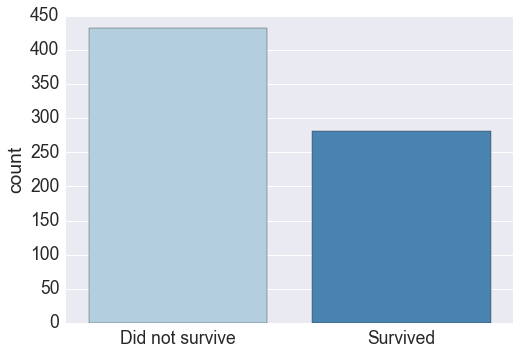

In [346]:
totl = sns.countplot(x='Survived', data=titanic_df, palette="Blues",order=[0,1],label = 'Total')
totl.set_xticklabels(["Did not survive","Survived"], rotation=0)
totl.set_xlabel(' ')

Overall survival rate was, as we know, not very good. To predict chances of survival for an individual, we will start off by looking at the data for each variable (column of data) individually, address missing/NaN data, and peak at the how the data looks. 

### Remove data that is not useful

In [347]:
# drop columns that will NOT be useful in analysis/prediction
# ie, the passenger id, name, and ticket number 
titanic_df = titanic_df.drop(['PassengerId','Name','Ticket'], axis=1)
test_df    = test_df.drop(['PassengerId','Name','Ticket'], axis=1)

# preview of revised data frame 
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
862,1,1,female,48.0,0,0,25.9292,D17,S
223,0,3,male,NaN,0,0,7.8958,NaN,S
84,1,2,female,17.0,0,0,10.5000,NaN,S
680,0,3,female,NaN,0,0,8.1375,NaN,Q
535,1,2,female,7.0,0,2,26.2500,NaN,S


### 1. Embarked 
 Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
 
 * Look at survival and survival rate associated with embarkation. 

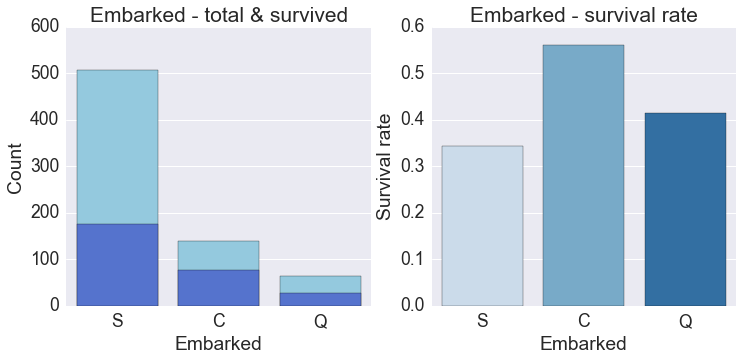

In [348]:
# ==============================================
sns.set(font_scale=1.5)  
sns.set(font_scale=1.75)  
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(12,5))
# how is embarked data distributed?
#===========================
# total per embarked
totl = sns.countplot(x='Embarked', data=titanic_df, color='skyblue',
                     order=['S','C','Q'],label = 'Total', ax=axis1)
#  survived
deck_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).sum()
surv = sns.barplot(x='Embarked', y='Survived', data=deck_perc,order=['S','C','Q'],color='royalblue', 
                   label = 'Survived', ax=axis1)
surv.set_xlabel('Embarked')
surv.set_ylabel('Count')
surv.set_title('Embarked - total & survived')
#===========================
# survival rate of Embarked data:
# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = titanic_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
survrt =sns.barplot(x='Embarked', y='Survived', data=embark_perc,order=['S','C','Q'],palette="Blues")
survrt.set_xlabel('Embarked')
survrt.set_ylabel('Survival rate')
survrt.set_title('Embarked - survival rate')

 EMBARKED: CONSIDER NOT USING... 
 if we are going to use Embarked data: we would need to fill or drop missing data, 
   we could make a dummy var and drop the S data because survival rate is low,
   or we could drop Embarked completely, because logically it shouldnt be helpful in prediction

 Lets just drop embarked, at least for now:

In [349]:
titanic_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'],    axis=1,inplace=True)
# ==============================================
# ==============================================

### 2. Fare 
Cost of ticket fare in dollars

Convert data float to int

In [350]:
titanic_df['Fare'] = titanic_df['Fare'].astype(int)
test_df['Fare']    = test_df['Fare'].astype(int)

Now, we can look at survival and survival rates associated with the paid Fare

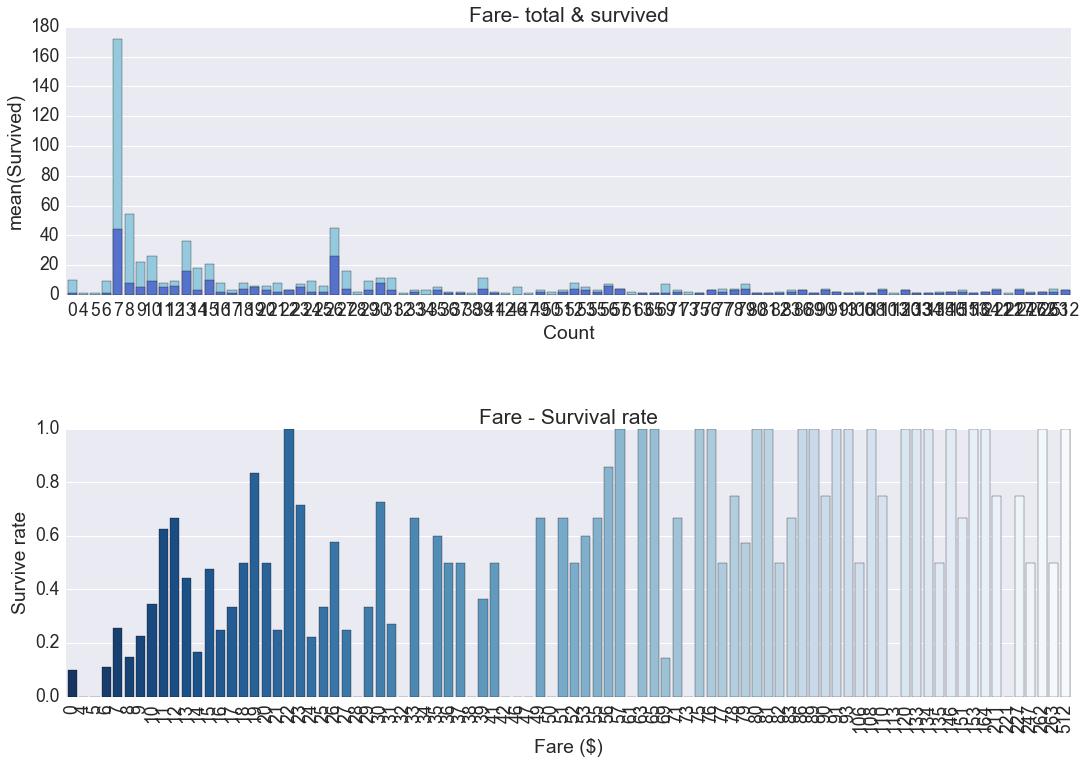

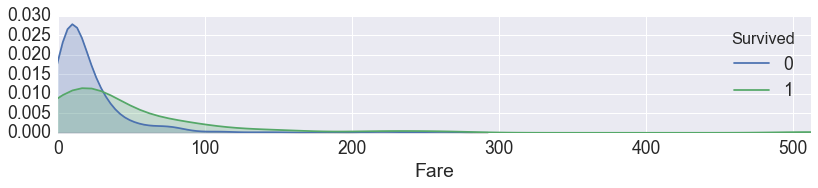

In [351]:
sns.set(font_scale=1.75)  
fig, (axis1, axis2) = plt.subplots(2,1,figsize=(18,12))
fig.subplots_adjust(hspace=.5)

#---------------------------------------
# total per embarked
totl = sns.countplot(x='Fare', data=titanic_df, color='skyblue',
                     label = 'Total', ax=axis1)
#  survived
deck_perc = titanic_df[["Fare", "Survived"]].groupby(['Fare'],as_index=False).sum()
surv = sns.barplot(x='Fare', y='Survived', data=deck_perc,color='royalblue', 
                   label = 'Survived', ax=axis1)
plt.xticks(rotation=90);
axis1.set_title('Fare- total & survived')
axis1.set_xlabel('Count')
#---------------------------------------
# survival 
ax2 = axis2
average_fare = titanic_df[["Fare", "Survived"]].groupby(['Fare'],as_index=False).mean()
fig2 = sns.barplot(x='Fare', y='Survived', data=average_fare,palette="Blues_r", ax=ax2)
ax2.set_title('Fare - Survival rate');
ax2.set_ylabel('Survive rate');
ax2.set_xlabel('Fare ($)');
#fig2.set(xlim=(0, 90))
plt.xticks(rotation=90);
#---------------------------------------
# peaks for survived/not survived passengers by Fare
facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4,legend_out=False)
facet = facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, titanic_df['Fare'].max()))
facet.add_legend()



Now, we can look at the average fare for those that that survived vs those that didnt. We know the data is highly populated towards the $5-20 range, so we can also look at the corresponding box plot, as well as compare the Fare among different passenger classes (Pclass):

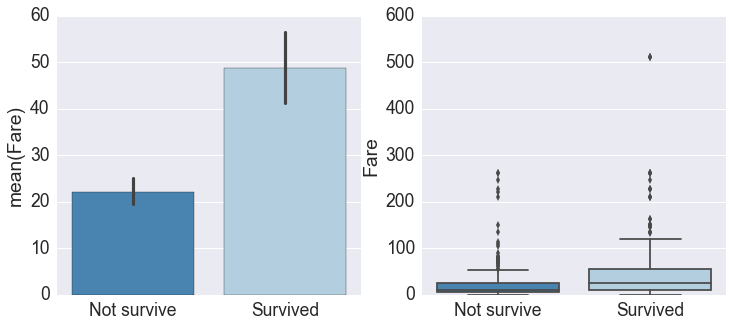

In [352]:
# Rate - survival ---------------------------------------
#----------------------------------------
sns.set(font_scale=1.75)  
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(12,5))

# Compare avg Fare for those that survived vs. those that didnt
embark_fare = titanic_df[["Fare", "Survived"]].groupby(['Fare'],as_index=False).mean()
surv = sns.barplot(x='Survived', y='Fare', data=titanic_df,order=[0,1],palette="Blues_r", ax=axis1)
surv.set_xticklabels(["Not survive","Survived"], rotation=0)
surv.set_xlabel(' ')
# boxplot
embark_fare = titanic_df[["Fare", "Survived"]].groupby(['Fare'],as_index=False).mean()
surv = sns.boxplot(x='Survived', y='Fare', data=titanic_df,order=[0,1],palette="Blues_r", ax=axis2)
surv.set_xticklabels(["Not survive","Survived"], rotation=0)
surv.set_xlabel(' ')



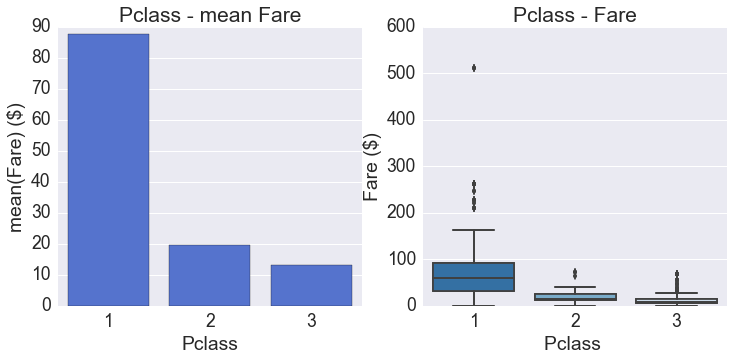

In [353]:
sns.set(font_scale=1.75)  
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(12,5))

# mean bar plot =============
deck_perc = titanic_df[["Fare", "Pclass"]].groupby(['Pclass'],as_index=False).mean()
surv = sns.barplot(x='Pclass', y='Fare', data=deck_perc,color='royalblue', 
                   label = 'Fare', ax=axis1)
surv.set_xlabel('Pclass')
surv.set_ylabel('mean(Fare) ($)')
surv.set_title('Pclass - mean Fare')


# boxplot====================
embark_fare = titanic_df[["Fare", "Pclass"]].groupby(['Pclass'],as_index=False).mean()
surv = sns.boxplot(x='Pclass', y='Fare', data=titanic_df,palette="Blues_r", ax=axis2)
surv.set_xlabel(' ')

embark_fare = titanic_df[["Fare", "Pclass"]].groupby(['Pclass'],as_index=False).mean()
surv = sns.boxplot(x='Pclass', y='Fare', data=titanic_df,palette="Blues_r", ax=axis2)
ax2 = axis2
ax2.set_title('Pclass - Fare');
ax2.set_ylabel('Fare ($)');
ax2.set_xlabel('Pclass ');





### 3. Age
Age in years from birth

Missing a lot of Age values for Test (332/418) and Train (714/891) data. We can replace these values w\ random variables that they fall within the mean/std of the values that we know for each data group.

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


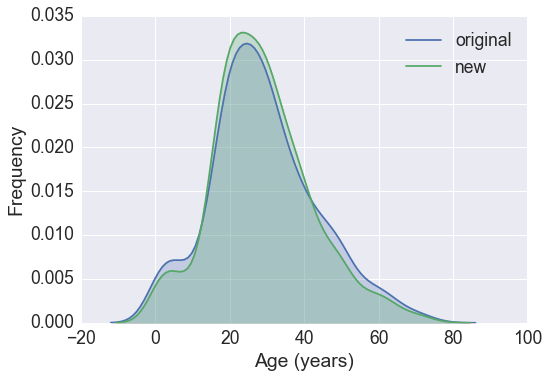

In [354]:
# 1. lets look at original data (drop nan vals, make integer, and plot): 
sns.kdeplot(titanic_df['Age'].dropna().astype(int), shade=True, label="original");

# 2. determine parameters for replacing nan's (mean+/-std)
# TRAIN data
# get average, std, and count of NaN values in titanic_df
average_age_titanic   = titanic_df["Age"].mean()
std_age_titanic       = titanic_df["Age"].std()
count_nan_age_titanic = titanic_df["Age"].isnull().sum()
# TEST data
# get average, std, and count of NaN values in test_df
average_age_test   = test_df["Age"].mean()
std_age_test       = test_df["Age"].std()
count_nan_age_test = test_df["Age"].isnull().sum()
# generate random numbers between (mean +/- std)
rand_titanic = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_test    = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)

# 3. Using rand vars, we can manipulate data
# first redefine variabls just so we can test how they look
# if test is 'succesful', we can swap vars later
# test only for titanic_df
titanic_df_ageTest = titanic_df;
test_df_ageTest = test_df;

# fill NaN vals in Age column with random values generated
titanic_df_ageTest["Age"][np.isnan(titanic_df_ageTest["Age"])] = rand_titanic
test_df_ageTest["Age"][np.isnan(test_df_ageTest["Age"])]       = rand_test

# plot
sns.kdeplot(titanic_df_ageTest['Age'].astype(int), shade=True, label="new");
plt.legend();
plt.xlabel('Age (years)')
plt.ylabel('Frequency')

This looks good, distribution looks relatively unchanged so lets replace our 'orignal' age data with the 'new'age data and plot the survival data wrt age.

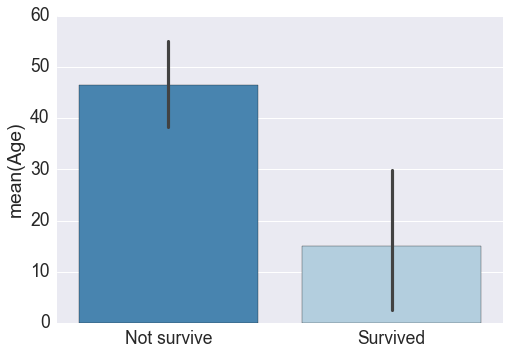

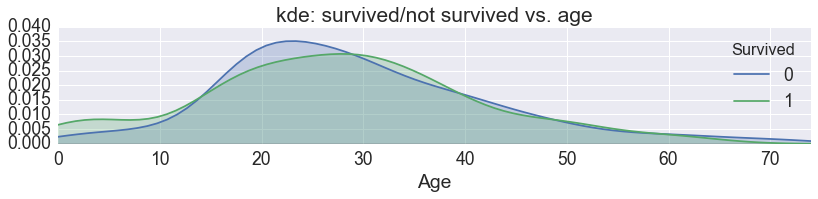

In [355]:
titanic_df = titanic_df_ageTest 
test_df    = test_df_ageTest

# plot survived
#----------------------------------------
# Compare avg Fare for those that survived vs. those that didnt
embark_fare = titanic_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
surv = sns.barplot(x='Survived', y='Age', data=embark_fare,order=[0,1],palette="Blues_r")
surv.set_xticklabels(["Not survive","Survived"], rotation=0)
plt.xlabel(' ')
#----------------------------------------
# peaks for survived/not survived passengers by their age
# kernel density estimation (KDE): non-parametric estimate of 
#      the probability density function of a rand var.
facet = sns.FacetGrid(titanic_df, hue="Survived",aspect=4,legend_out=False)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, titanic_df['Age'].max()))
facet.add_legend()
plt.title('kde: survived/not survived vs. age')


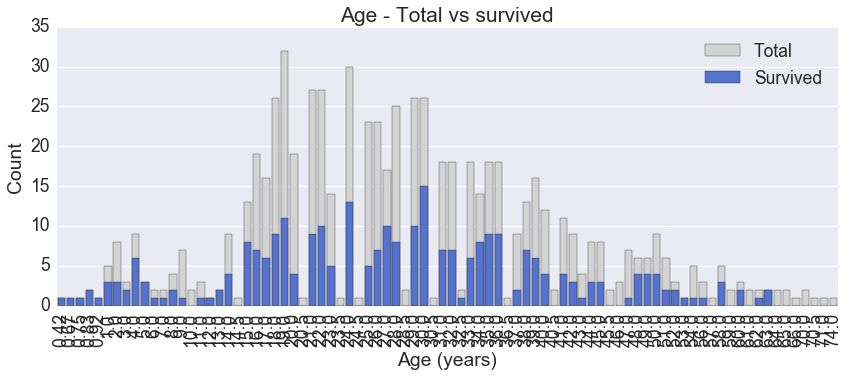

In [356]:
# Age... survived vs total passengers as a function of age
average_age = titanic_df[["Age", "Survived"]].groupby(['Age'],as_index=False).sum()

plt.figure(figsize=(14,5)) #figsize=(15,5)
totl = sns.countplot(x='Age', data=titanic_df,color='lightgrey',label = 'Total')
surv = sns.barplot(x='Age', y='Survived', data=average_age,color='royalblue',label='Survived')
#ax2.set_title('Survival Rate by age')
plt.legend();
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.title('Age - Total vs survived')
plt.xticks(rotation=90);

Things to consider: break this group up... average age of survivors is less than that of those that didnt survive. But, we know this data is likely heavily skewed and there is a large range of ages. 

"baby" 0-1 or 2, child 1/2-12, adolescent 12-16, young adult 17/18, elderly >60?

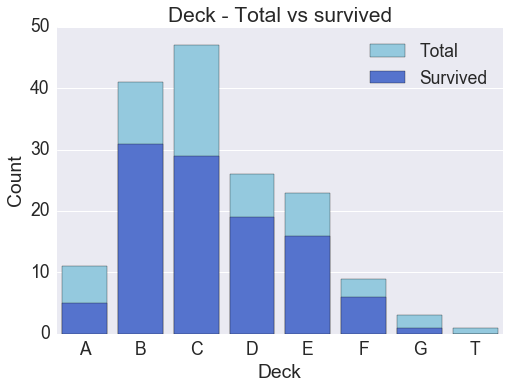

In [357]:
# ==============================================
# 4. Cabin =====================================
# cabin: deck level (A-G, T) and room number
# 1st-3rd class passengers distributed throughout each
# ==============================================

titanic_dftemp = titanic_df["Cabin"].dropna()
sns.countplot(x=titanic_dftemp,ax=axis1,palette="Blues")

# cabin and room number might not be directly useful, but maybe the deck level of each is
# lets make a new column only looking at the deck info
titanic_df['Deck'] = titanic_df['Cabin'].dropna().astype(str).str[0]

#--------------------------------
# plot
# total per deck
totl = sns.countplot(x='Deck', data=titanic_df, color='skyblue',order=['A','B','C','D','E','F','G','T'],label = 'Total')
#  survived
deck_perc = titanic_df[["Deck", "Survived"]].groupby(['Deck'],as_index=False).sum()
surv = sns.barplot(x='Deck', y='Survived', data=deck_perc,order=['A','B','C','D','E','F','G','T'],color='royalblue', label = 'Survived')
#plt opts
plt.legend();
plt.xlabel('Deck')
plt.ylabel('Count')
plt.title('Deck - Total vs survived')


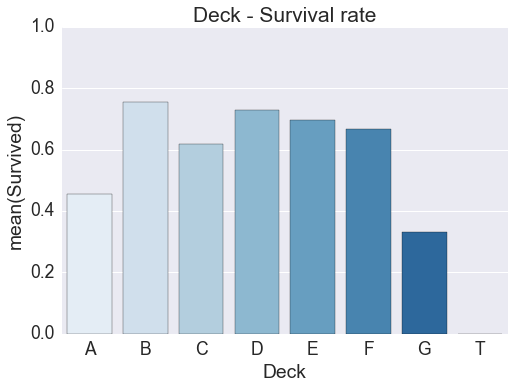

In [358]:
# survival rate
embark_perc = titanic_df[["Deck", "Survived"]].groupby(['Deck'],as_index=False).mean()
sns.barplot(x='Deck', y='Survived', data=embark_perc,
            order=['A','B','C','D','E','F','G','T'],palette="Blues")
plt.ylim(0,1);
plt.title('Deck - Survival rate')

In [359]:
# DECK & Cabin: CONSIDER NOT USING... ------------------------------------------------
# This is interesting data, but survival rates are comparable among each deck.
# And, there is a LOT of missing data (204/891)
# hence, for now, lets drop the Deck and Cabin information
# --------------------------------------------------------------------------------

# It has a lot of NaN values, so it won't cause a remarkable impact on prediction
titanic_df.drop("Cabin",axis=1,inplace=True)
test_df.drop("Cabin",axis=1,inplace=True)

# Cabin:
titanic_df.drop(['Deck'], axis=1,inplace=True)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


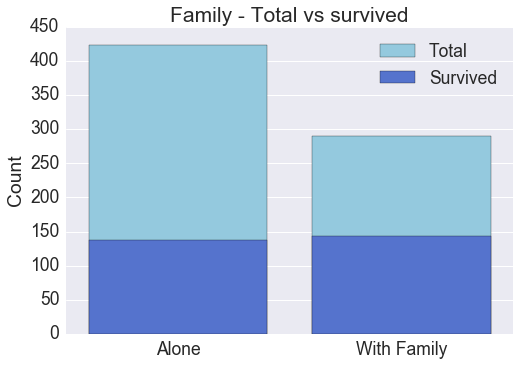

In [360]:
# ==============================================
# 5. Family =====================================
# SibSp (# Siblings/Spouses) and Parch (# Parents/Spouses) -- 
# note, cousins, nephews/nieces, aunts/uncles, spouses, and in-laws not counted.
# ==============================================

# lets combine these to identify families vs. those traveling seperately 
# titanic_df
titanic_df['Family'] =  titanic_df["Parch"] + titanic_df["SibSp"]
titanic_df['Family'].loc[titanic_df['Family'] > 0] = 1
titanic_df['Family'].loc[titanic_df['Family'] == 0] = 0
# test_df
test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
test_df['Family'].loc[test_df['Family'] > 0] = 1
test_df['Family'].loc[test_df['Family'] == 0] = 0


#--------------------------------
# plot
# total per deck
totl = sns.countplot(x='Family', data=titanic_df, color='skyblue',order=[0,1],label = 'Total')
#  survived
deck_perc = titanic_df[["Family", "Survived"]].groupby(['Family'],as_index=False).sum()
surv = sns.barplot(x='Family', y='Survived', data=deck_perc,order=[0,1],color='royalblue', label = 'Survived')
#plt opts
surv.set_xticklabels(["Alone","With Family"], rotation=0)
plt.legend();
plt.ylabel('Count')
plt.xlabel(' ')
plt.title('Family - Total vs survived')

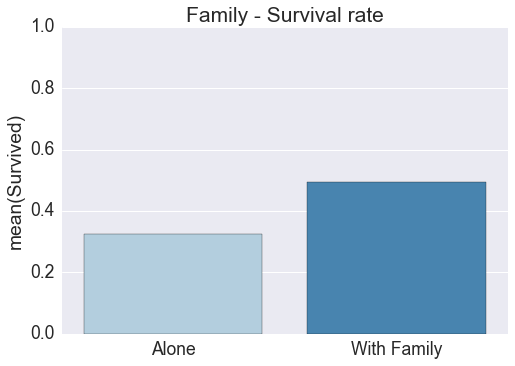

In [361]:
# survival rate
embark_perc = titanic_df[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
survrate = sns.barplot(x='Family', y='Survived', data=embark_perc,
            order=[0,1],palette="Blues")
plt.ylim(0,1);
plt.title('Family - Survival rate')
survrate.set_xticklabels(["Alone","With Family"], rotation=0)
survrate.set_xlabel(' ')

In [260]:
# now we can drop Parch & SibSp
#titanic_df = titanic_df.drop(['SibSp','Parch'], axis=1)
#test_df    = test_df.drop(['SibSp','Parch'], axis=1)


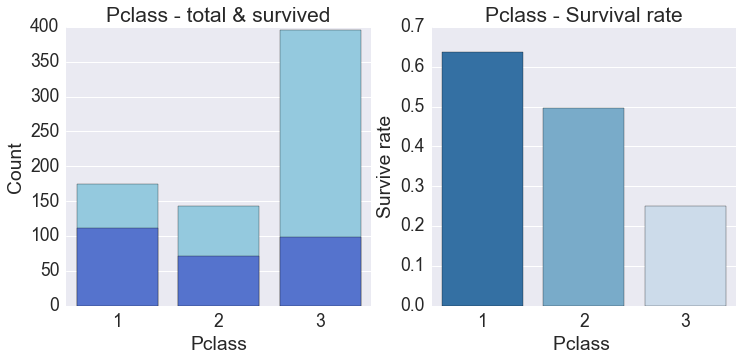

In [362]:
fig, (axis1, axis2) = plt.subplots(1,2,figsize=(12,5))
#--------------------
# total per embarked
totl = sns.countplot(x='Pclass', data=titanic_df, color='skyblue',
                     label = 'Total', ax=axis1)
#  survived
deck_perc = titanic_df[["Pclass", "Survived"]].groupby(['Pclass'],as_index=False).sum()
surv = sns.barplot(x='Pclass', y='Survived', data=deck_perc,color='royalblue', 
                   label = 'Survived', ax=axis1)
surv.set_xlabel('Pclass')
surv.set_ylabel('Count')
surv.set_title('Pclass - total & survived')

#===============================================
ax2 = axis2
average_fare = titanic_df[["Pclass", "Survived"]].groupby(['Pclass'],as_index=False).mean()
fig2 = sns.barplot(x='Pclass', y='Survived', data=average_fare,palette="Blues_r", ax=ax2)
ax2.set_title('Pclass - Survival rate');
ax2.set_ylabel('Survive rate');
ax2.set_xlabel('Pclass ');
#fig2.set(xlim=(0, 90))

In [363]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    if age < 16:
        return 'child'
    elif age>= 65:
        return 'senior'
    else: 
        return sex
    
titanic_df['Person'] = titanic_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
titanic_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column, & drop Male as it has the lowest average of survived passengers
person_dummies_titanic  = pd.get_dummies(titanic_df['Person'])
person_dummies_titanic.columns = ['Child','Senior','Female','Male']
person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Senior','Female','Male']
person_dummies_test.drop(['Male'], axis=1, inplace=True)

titanic_df = titanic_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)

ValueError: Could not interpret input 'Person'

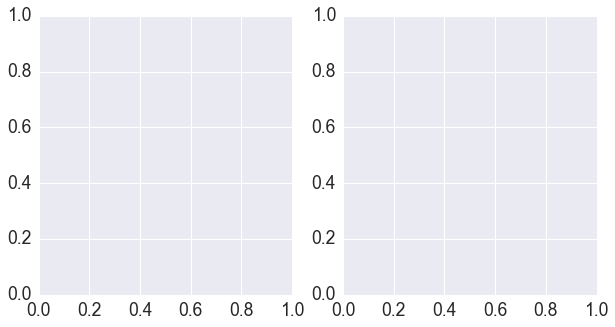

In [371]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

# sns.factorplot('Person',data=titanic_df,kind='count',ax=axis1)
sns.countplot(x='Person', data=titanic_df, palette="Blues_r",ax=axis1)

# average of survived for each Person(male, female, or child)
person_perc = titanic_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, palette="Blues_r", order=['male','female','child','senior'])

titanic_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

In [376]:
# define training and testing sets
X_train = titanic_df.drop("Survived",axis=1)
Y_train = titanic_df["Survived"]

X_test  = test_df.drop("Survived",axis=1)
Y_test  = test_df["Survived"]

print(X_train.shape)
X_train.head()


(713, 9)


,Pclass,Age,SibSp,Parch,Fare,Family,Child,Senior,Female
862,1,48.0,0,0,25,0,0.0,1.0,0.0
223,3,20.0,0,0,7,0,0.0,0.0,1.0
84,2,17.0,0,0,10,0,0.0,1.0,0.0
680,3,25.0,0,0,8,0,0.0,1.0,0.0
535,2,7.0,0,2,26,1,1.0,0.0,0.0


### logistic regression
Lets try logistic regression first

In [382]:
# Logistic Regression
LogRegModel = LogisticRegression()
LogRegModel.fit(X_train, Y_train)
predictions = LogRegModel.predict(X_test)

scoreval = LogRegModel.score(X_train, Y_train)
MSE = mean_squared_error(predictions, Y_test)

print('MSE = ' + str(MSE))
print('Model score = ' + str(scoreval))


MSE = 0.174157303371
Model score = 0.816269284712


In [378]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(titanic_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(LogRegModel.coef_[0])
# preview
coeff_df

,Features,Coefficient Estimate
0,Pclass,-0.839238
1,Age,-0.023160
2,SibSp,-0.553353
3,Parch,-0.383913
4,Fare,0.003798
5,Family,0.593876
6,Child,1.552965
7,Senior,2.251528
8,Female,-0.643588


### Random Forests 
Now we can try a random forest for comparison (note the score compared to regression score)

In [380]:
# Random Forests
randForestModel = RandomForestClassifier(n_estimators=100)
randForestModel.fit(X_train, Y_train)
predictions = randForestModel.predict(X_test)

# Compute the error.
MSE = mean_squared_error(predictions, Y_test)
scoreval = randForestModel.score(X_train, Y_train)

print('MSE = ' + str(MSE))
print('Model score = ' + str(scoreval))

MSE = 0.179775280899
Model score = 0.959326788219
